In [14]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from hd_extension import *

In [13]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Social_Pref/nac"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Social_Pref/nac_csvs"
brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

In [14]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Social_Pref/nac/nn2-250117-085631/Notes.txt
read from t=0s to t=814.05s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Social_Pref/nac/nn4-250118-094351/Notes.txt
read from t=0s to t=795.95s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Social_Pref/nac/nn1-250117-081652/Notes.txt
read from t=0s to t=870.75s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Social_Pref/nac/nn8-250118-105443/Notes.txt
read from t=0s to t=795.34s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Social_Pref/nac/nn7-250118-101917/Notes.txt
read from t=0s to t=796.74s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Social_Pref/nac/nn6-250117-101903/Notes.txt
read from t=0s to t=794.16s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine

In [15]:
bout_definitions = [
    {'prefix': 's1', 'introduced': 's1_Introduced', 'removed': 's1_Removed'},
    {'prefix': 's2', 'introduced': 's2_Introduced', 'removed': 's2_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for nn2-250117-085631...
Processing behaviors for nn4-250118-094351...
Processing behaviors for nn1-250117-081652...
Processing behaviors for nn8-250118-105443...
Processing behaviors for nn7-250118-101917...
Processing behaviors for nn6-250117-101903...
Processing behaviors for nn3-250118-090940...
Processing behaviors for nn5-250117-093631...


# Total Investigation Time & Average Bout Duration

In [17]:
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

exp_dict = get_trial_dataframes(experiment)
metadata_df = create_metadata_dataframe(exp_dict, behavior="Investigation", desired_bouts=desired_bouts)
metadata_df

KeyError: 'Bout'

In [37]:
def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.

    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_invest_time / number_of_bouts

    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1

    for i, df in enumerate(dfs):
        if 'Duration (s)' not in df.columns or 'Bout' not in df.columns:
            print(f"Skipping DataFrame {i}: missing 'Duration (s)' or 'Bout' column.")
            continue  # Skip this one

        temp_df = df.copy()
        temp_df["Subject"] = subject_id

        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0

        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur

        processed_list.append(temp_df)
        subject_id += 1

    if processed_list:
        final_df = pd.concat(processed_list, ignore_index=True)
    else:
        final_df = pd.DataFrame()  # Return empty if no valid data
    return final_df


In [38]:
def process_investigation_data(df, 
                               behavior_name='Investigation', 
                               gap_threshold=1.0, 
                               min_duration=0.5,
                               desired_bouts=None,
                               agg_func='sum'):
    """
    Merge consecutive Investigation events within 'gap_threshold' seconds,
    remove events shorter than 'min_duration', then group/pivot by Subject & Bout.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: [Subject, Behavior, Bout, Event_Start, Event_End, Duration (s)]
    behavior_name : str
        Which behavior to combine/filter (default 'Investigation').
    gap_threshold : float
        Max gap (in seconds) to consider consecutive events mergeable.
    min_duration : float
        Minimum duration below which events are removed.
    desired_bouts : list or None
        Which bouts to keep (if None, keep all).
    agg_func : {'sum', 'mean'}
        How to combine the durations in the final group step.
        
    Returns
    -------
    pivot_df : pd.DataFrame
        Pivoted DataFrame of aggregated durations by Subject × Bout.
    """
    
    #--- 1) Keep only rows matching the specified behavior ---
    df = df[df["Behavior"] == behavior_name].copy()
    
    #--- 2) Sort so consecutive events are truly consecutive by subject & start time ---
    df.sort_values(["Subject", "Event_Start"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    #--- 3) Identify which rows should *not* merge with their predecessor ---
    df["new_block"] = (
        (df["Subject"] != df["Subject"].shift(1)) |
        (df["Event_Start"] - df["Event_End"].shift(1) > gap_threshold)
    )
    df["group_id"] = df["new_block"].cumsum()
    
    #--- 4) Merge consecutive events in each group_id ---
    merged = (
        df.groupby("group_id", as_index=False)
          .agg({
              "Subject":      "first",
              "Behavior":     "first",
              "Bout":         "first",  # Uses the first bout label in the block
              "Event_Start":  "min",
              "Event_End":    "max",
              "Duration (s)": "sum"
          })
    )
    
    #--- 5) Remove events shorter than min_duration ---
    merged = merged[merged["Duration (s)"] >= min_duration].copy()
    
    #--- 6) Filter by desired bouts (if provided) ---
    if desired_bouts is not None:
        merged = merged[merged["Bout"].isin(desired_bouts)]
    
    #--- 7) Group by Subject & Bout with either sum or mean, then pivot ---
    if agg_func == 'sum':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
    elif agg_func == 'mean':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
    else:
        raise ValueError("agg_func must be either 'sum' or 'mean'")
    
    pivot_df = (
        grouped_df
        .pivot(index="Subject", columns="Bout", values="Duration (s)")
        .fillna(0)
    )
    
    return pivot_df


In [39]:
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    behavior_name="Investigation",   # or "Approach" if you prefer
    gap_threshold=0.3,
    min_duration=.00000000000000001,
    desired_bouts=desired_bouts,
    agg_func='sum'
)

Skipping DataFrame 0: missing 'Duration (s)' or 'Bout' column.
Skipping DataFrame 1: missing 'Duration (s)' or 'Bout' column.
Skipping DataFrame 2: missing 'Duration (s)' or 'Bout' column.
Skipping DataFrame 3: missing 'Duration (s)' or 'Bout' column.
Skipping DataFrame 4: missing 'Duration (s)' or 'Bout' column.
Skipping DataFrame 5: missing 'Duration (s)' or 'Bout' column.
Skipping DataFrame 6: missing 'Duration (s)' or 'Bout' column.
Skipping DataFrame 7: missing 'Duration (s)' or 'Bout' column.


KeyError: 'Behavior'

In [ ]:
dfs

[    Bout       Behavior  Event_Start  Event_End  Duration (s)
 0   s1-1  Investigation      190.600    192.900         2.300
 1   s1-1  Investigation      197.400    257.700        60.300
 2   s1-1  Investigation      264.500    306.100        41.600
 3   s1-2       Approach      391.500    392.400         0.900
 4   s1-2       Approach      483.900    486.600         2.700
 5   s1-2  Investigation      376.500    384.700         8.200
 6   s1-2  Investigation      392.399    392.400         0.001
 7   s1-2  Investigation      396.700    402.000         5.300
 8   s1-2  Investigation      403.500    414.300        10.800
 9   s1-2  Investigation      417.100    418.200         1.100
 10  s1-2  Investigation      419.300    441.400        22.100
 11  s1-2  Investigation      456.800    460.700         3.900
 12  s1-2  Investigation      462.100    483.899        21.799
 13  s1-2  Investigation      486.599    486.600         0.001
 14  s1-3  Investigation      571.100    575.100       

In [ ]:
pivot

Bout,s1-1,s1-2,s1-3,s1-4,s1-5,s2-1
Subject,,,,,,
1,34.733333,8.133444,4.775000,1.020000,1.600000,9.837500
2,10.599750,6.487000,6.033167,2.883083,6.466667,2.637500
3,5.500000,1.040000,1.700200,0.916667,4.720000,9.740200
4,3.052941,2.625000,2.675000,1.566667,2.450000,2.066667
5,6.633125,1.752286,4.939364,3.044444,4.613400,4.499917
6,4.181818,2.375000,0.960000,1.550000,3.433333,5.360000
7,4.600000,4.150000,0.725000,1.475000,1.460000,2.020000
8,4.620100,4.257286,5.739900,2.024875,2.311167,8.489000
9,7.150000,1.940000,1.325000,1.883333,2.614286,4.666667


In [ ]:
def plot_y_across_bouts_gray(df,  
                             title='Mean Across Bouts', 
                             ylabel='Mean Value', 
                             custom_xtick_labels=None, 
                             custom_xtick_colors=None, 
                             ylim=None, 
                             bar_color='#00B7D7',
                             yticks_increment=None, 
                             xlabel='Agent',
                             figsize=(12,7), 
                             pad_inches=0.1):
    """
    Plots the mean values (with SEM) across bouts with individual-subject lines.
    Also performs a paired t-test comparing the average of s1-1 & s1-2 vs. the
    average of s1-5 & s2-2, drawing a significance line if p < 0.05.

    Parameters:
        - df (DataFrame): A DataFrame where rows are subjects, and bouts are columns.
                          Values are the mean values (e.g., mean DA, investigation times)
                          for each subject and bout.
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - custom_xtick_labels (list): Custom x-tick labels. If not provided,
                                      defaults to df column names.
        - custom_xtick_colors (list): A list of colors for the x-tick labels.
        - ylim (tuple): (min, max) for y-axis. If None, automatically set.
        - bar_color (str): The color for the bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - xlabel (str): The label for the x-axis.
        - figsize (tuple): The figure size.
        - pad_inches (float): Figure padding when saving.
    """
    # Calculate mean and SEM
    mean_values = df.mean()
    sem_values = df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Bar plot with error bars
    bars = ax.bar(
        df.columns, 
        mean_values, 
        yerr=sem_values, 
        capsize=6,
        color=bar_color,
        edgecolor='black', 
        linewidth=5,
        width=0.6,
        error_kw=dict(elinewidth=3, capthick=3, zorder=5)
    )

    # Plot all subject lines in gray
    for subject in df.index:
        ax.plot(df.columns, df.loc[subject],
                linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

    # Plot unfilled circle markers (larger size) in gray
    for subject in df.index:
        ax.scatter(df.columns, df.loc[subject], 
                   facecolors='none', edgecolors='gray',
                   s=120, alpha=0.6, linewidth=4, zorder=2)

    # Labels & Title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # Set x-ticks
    ax.set_xticks(np.arange(len(df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df.columns, fontsize=26)

    # Increase tick label size
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # Handle y-limits
    if ylim is None:
        # Automatically set based on data range
        all_values = np.concatenate([df.values.flatten(), mean_values.values.flatten()])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # Set y-ticks if increment is provided
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min),
                            np.ceil(y_max) + yticks_increment,
                            yticks_increment)
        ax.set_yticks(y_ticks)

    # Remove right & top spines, thicken left & bottom
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # -----------------------------------------------------
    #  Perform paired t-test: (s1-1 + s1-2) vs. (s1-5 + s2-2)
    # -----------------------------------------------------
    required_cols = {'s1-1', 's1-2', 's1-5', 's2-2'}
    if required_cols.issubset(set(df.columns)):
        from scipy.stats import ttest_rel
        group1 = df[['s1-1', 's1-2']].mean(axis=1)
        group2 = df[['s1-5', 's2-2']].mean(axis=1)
        t_stat, p_val = ttest_rel(group1, group2)

        # Determine significance symbol
        if p_val < 0.001:
            sig_symbol = '***'
        elif p_val < 0.01:
            sig_symbol = '**'
        elif p_val < 0.05:
            sig_symbol = '*'
        else:
            sig_symbol = None

        if sig_symbol is not None:
            # Find the x-indices for these columns
            x_s11 = df.columns.get_loc('s1-1')
            x_s12 = df.columns.get_loc('s1-2')
            x_s15 = df.columns.get_loc('s1-5')
            x_s22 = df.columns.get_loc('s2-2')

            # We'll place a line spanning the “mean of s1-1 & s1-2” group
            # to the “mean of s1-5 & s2-2” group.
            x1 = (x_s11 + x_s12) / 2
            x2 = (x_s15 + x_s22) / 2

            # Determine a suitable y-position: 
            # take the highest bar+SEM among the four columns
            bars_of_interest = ['s1-1', 's1-2', 's1-5', 's2-2']
            max_height = 0
            for c in bars_of_interest:
                bar_top = mean_values[c] + sem_values[c]
                if bar_top > max_height:
                    max_height = bar_top

            # We'll add 3% on top of that highest bar
            line_y = max_height * 1.03
            # A small offset to place the text above the line
            text_offset = 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])  

            # Draw a simple horizontal line
            ax.hlines(y=line_y, xmin=x1, xmax=x2, colors='black', linewidth=2)

            # Place the significance text in the middle, above the line
            ax.text((x1 + x2)/2, line_y + text_offset,
                    sig_symbol, ha='center', va='bottom',
                    color='black', fontsize=26)
    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout()
    plt.show()


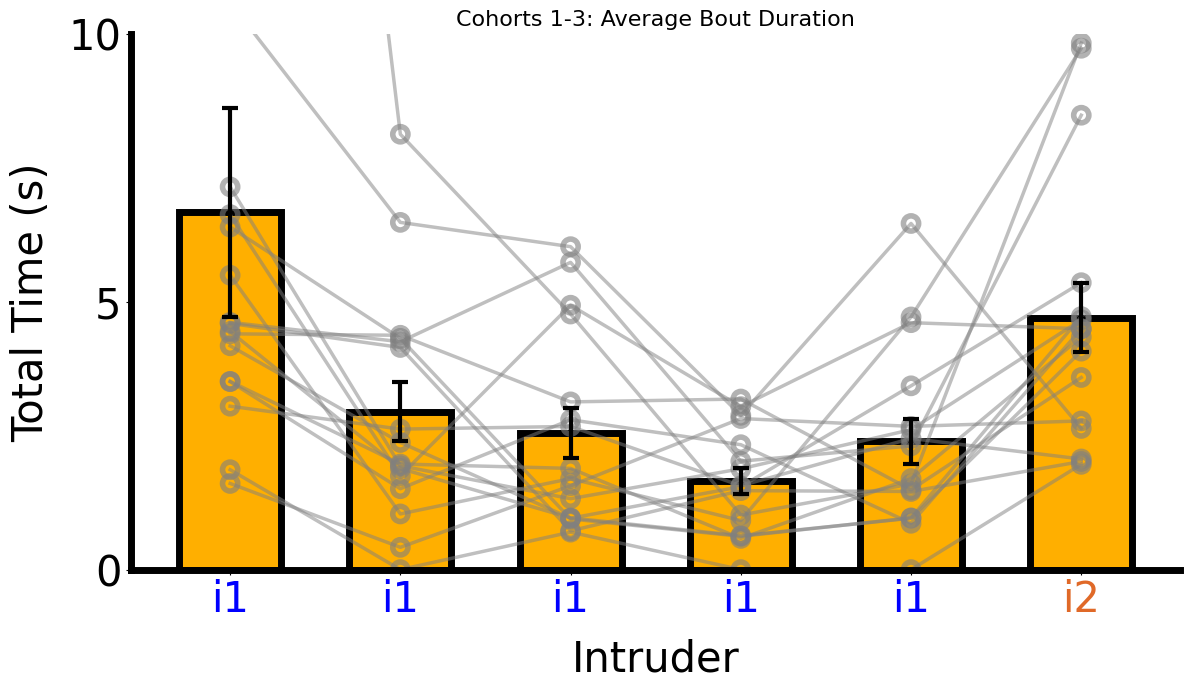

In [ ]:
plot_y_across_bouts_gray(
    df=pivot,
    title="Cohorts 1-3: Average Bout Duration",
    ylabel="Total Time (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 10),
    bar_color=brain_region,
    yticks_increment=5,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

# Dopamine Analysis

### Global

In [ ]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first = True)
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions)

# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(
    use_fractional=True,       # Enable fractional analysis (limits window to max_bout_duration)
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    peak_fall_fraction=0.6,    # Set the fall threshold to 60% of the peak
    allow_bout_extension=True, # Allow extending the bout window if needed
    first=True                 # Consider only the first investigation event per bout
)

Processing behaviors for n3-240509-062454...
Processing behaviors for n5-240823-085032...
Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for n6-240823-101436...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for n4-240509-075317...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...
Processing behaviors for n2-240508-092906...
Processing behaviors for n7-240824-062103...
Processing behaviors for n1-240508-080051...
Processing behaviors for n3-240509-062454...
Processing behaviors for n5-240823-085032...
Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for n6-240823-101436..

In [ ]:
def plot_da_metrics_combined_oneplot_integrated(experiment, 
                                                metric_name="Mean Z-score", 
                                                title="Combined DA Metrics", 
                                                ylabel="DA Metric", 
                                                xlabel="Bout", 
                                                custom_xtick_labels=None, 
                                                custom_xtick_colors=None, 
                                                ylim=None, 
                                                bar_color="#00B7D7", 
                                                yticks_increment=None, 
                                                figsize=(14,8), 
                                                pad_inches=0.1):
    """
    Plots the computed DA metrics across 6 specific bouts for all trials in the experiment.
    If p-value < 0.05, it adds a horizontal significance line + asterisk above the bars.

    Updates:
    - Unfilled circle markers for individual trials
    - Thick grey outlines for visibility

    Parameters:
        - experiment: The experiment object (with a dictionary attribute `trials`).
        - metric_name (str): The DA metric to plot (e.g., "Mean Z-score").
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - xlabel (str): The label for the x-axis.
        - custom_xtick_labels (list): A list of exactly 6 x-tick labels (default: ["i1", "i1", "i1", "i1", "i1", "i2"]).
        - custom_xtick_colors (list): A list of colors for the x-tick labels.
        - ylim (tuple): Y-axis limits.
        - bar_color (str): Color for bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - figsize (tuple): Figure size.
        - pad_inches (float): Padding around the figure.
    """

    # Collect per-trial data (grouped by Bout for the chosen metric)
    trial_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            if metric_name not in df.columns:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'. Skipping.")
                continue
            df_grouped = df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name
            trial_data.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")

    if not trial_data:
        print("No data available to plot.")
        return

    # Combine all trial data into a single DataFrame.
    combined_df = pd.concat(trial_data, ignore_index=True)

    # Select only 6 bouts: first 5 as "i1", last one as "i2"
    selected_bouts = combined_df["Bout"].unique()[:6]
    combined_df = combined_df[combined_df["Bout"].isin(selected_bouts)]

    # Pivot the data for the line plots: rows=Trial, columns=Bout, values=metric_name.
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name)
    except Exception as e:
        print("Error pivoting data for line plots:", e)
        return
    pivot_df = pivot_df.fillna(0)

    # Compute overall average and SEM for each Bout across all trials.
    overall_stats = combined_df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()

    # Create the figure and a single axis.
    fig, ax = plt.subplots(figsize=figsize, facecolor="none")  # Transparent background

    # Plot the overall average as a bar chart with error bars.
    ax.bar(overall_stats["Bout"], overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))
    
    # Overlay individual trial lines (all in gray).
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], linestyle='-', color='gray', 
                alpha=0.5, linewidth=3, marker='o', markerfacecolor='none', markeredgecolor='gray', markeredgewidth=2, markersize=10)

    # Set labels and title.
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    if title is not None:
        ax.set_title(title, fontsize=28)

    # **Set exactly 6 x-tick labels**
    xtick_labels = ["i1", "i1", "i1", "i1", "i1", "i2"]
    xtick_colors = ["blue", "blue", "blue", "blue", "blue", "#E06928"]

    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(xtick_labels, fontsize=28)

    # Apply custom colors
    for tick, color in zip(ax.get_xticklabels(), xtick_colors):
        tick.set_color(color)

    # Increase tick label sizes.
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)
    
    # Set y-limits.
    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    
    # Set y-ticks based on yticks_increment if provided.
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)
    
    # Remove right and top spines, adjust left and bottom spine width.
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    
    # ---- Perform Paired T-tests ---- #
    def perform_t_tests_on_bouts(experiment, metric_name="Mean Z-score"):
        """Performs paired t-tests between Bout 1 & 2 and Bout 5 & 6."""
        trial_data = []
        for trial_name, trial in experiment.trials.items():
            if hasattr(trial, "behaviors") and not trial.behaviors.empty:
                df = trial.behaviors.copy()
                if metric_name not in df.columns:
                    continue
                df_grouped = df.groupby("Bout", as_index=False)[metric_name].mean()
                df_grouped["Trial"] = trial_name
                trial_data.append(df_grouped)

        if not trial_data:
            return None

        combined_df = pd.concat(trial_data, ignore_index=True)
        selected_bouts = combined_df["Bout"].unique()

        if len(selected_bouts) < 6:
            return None

        bout_1 = combined_df[combined_df["Bout"] == selected_bouts[0]][metric_name].values
        bout_2 = combined_df[combined_df["Bout"] == selected_bouts[1]][metric_name].values
        bout_5 = combined_df[combined_df["Bout"] == selected_bouts[4]][metric_name].values
        bout_6 = combined_df[combined_df["Bout"] == selected_bouts[5]][metric_name].values

        min_length_1 = min(len(bout_1), len(bout_2))
        min_length_2 = min(len(bout_5), len(bout_6))

        bout_1, bout_2 = bout_1[:min_length_1], bout_2[:min_length_1]
        bout_5, bout_6 = bout_5[:min_length_2], bout_6[:min_length_2]

        t_stat_1, p_value_1 = ttest_rel(bout_1, bout_2)
        t_stat_2, p_value_2 = ttest_rel(bout_5, bout_6)

        return {"t_stat_1": t_stat_1, "p_value_1": p_value_1, "t_stat_2": t_stat_2, "p_value_2": p_value_2}

    # Get t-test results
    t_test_results = perform_t_tests_on_bouts(experiment, metric_name)

    # ---- Plot significance markers ---- #
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05  # Offset above error bars

        if t_test_results["p_value_1"] < 0.05:
            x1, x2 = 0, 1  # Bout 1 and Bout 2 positions
            y = overall_stats["mean"].max() + sig_y_offset
            ax.plot([x1, x2], [y, y], color='black', linewidth=5)  # Horizontal line
            ax.text((x1 + x2) / 2, y + sig_y_offset / 2, "*", fontsize=40, ha='center', color='black')

        if t_test_results["p_value_2"] < 0.05:
            x1, x2 = 4, 5  # Bout 5 and Bout 6 positions
            y = overall_stats["mean"].max() + sig_y_offset
            ax.plot([x1, x2], [y, y], color='black', linewidth=5)  # Horizontal line
            ax.text((x1 + x2) / 2, y + sig_y_offset / 2, "*", fontsize=40, ha='center', color='black')

    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout(pad=pad_inches)
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

plot_da_metrics_combined_oneplot_integrated(experiment,  # Use the subset
                                            metric_name="Max Peak", 
                                            title="Cohorts 1-3: Global DA (Peak)", 
                                            ylabel="Peak", 
                                            xlabel="Bout", 
                                            custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
                                            custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"], 
                                            ylim=(-2, 8), 
                                            bar_color=brain_region, 
                                            yticks_increment=2,
                                            figsize=(14,8), 
                                            pad_inches=0.1)

# Mean Z-score ΔF/F
#plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)

No data available to plot.


In [ ]:
for name, trial in experiment.trials.items():
    if hasattr(trial, 'behaviors'):
        print(f"{name}: {len(trial.behaviors)} rows")
    else:
        print(f"{name}: No behaviors attribute")


n3-240509-062454: 0 rows
n5-240823-085032: 0 rows
nn4-250121-084228: 0 rows
nn7-250121-094048: 0 rows
nn8-250121-101912: 0 rows
nn6-250120-085156: 0 rows
n6-240823-101436: 0 rows
nn5-250120-081227: 0 rows
nn1-250120-063024: 0 rows
n4-240509-075317: 0 rows
nn3-250121-074834: 0 rows
nn2-250120-072910: 0 rows
n2-240508-092906: 0 rows
n7-240824-062103: 0 rows
n1-240508-080051: 0 rows


In [ ]:
# double checking the p-values
from scipy.stats import ttest_rel
import pandas as pd

t_test_results = perform_t_tests_on_bouts(experiment, metric_name="AUC")

T-test between bout 1 and bout 2: t-statistic = 2.3909, p-value = 0.0314
T-test between bout 5 and bout 6: t-statistic = -2.7784, p-value = 0.0148


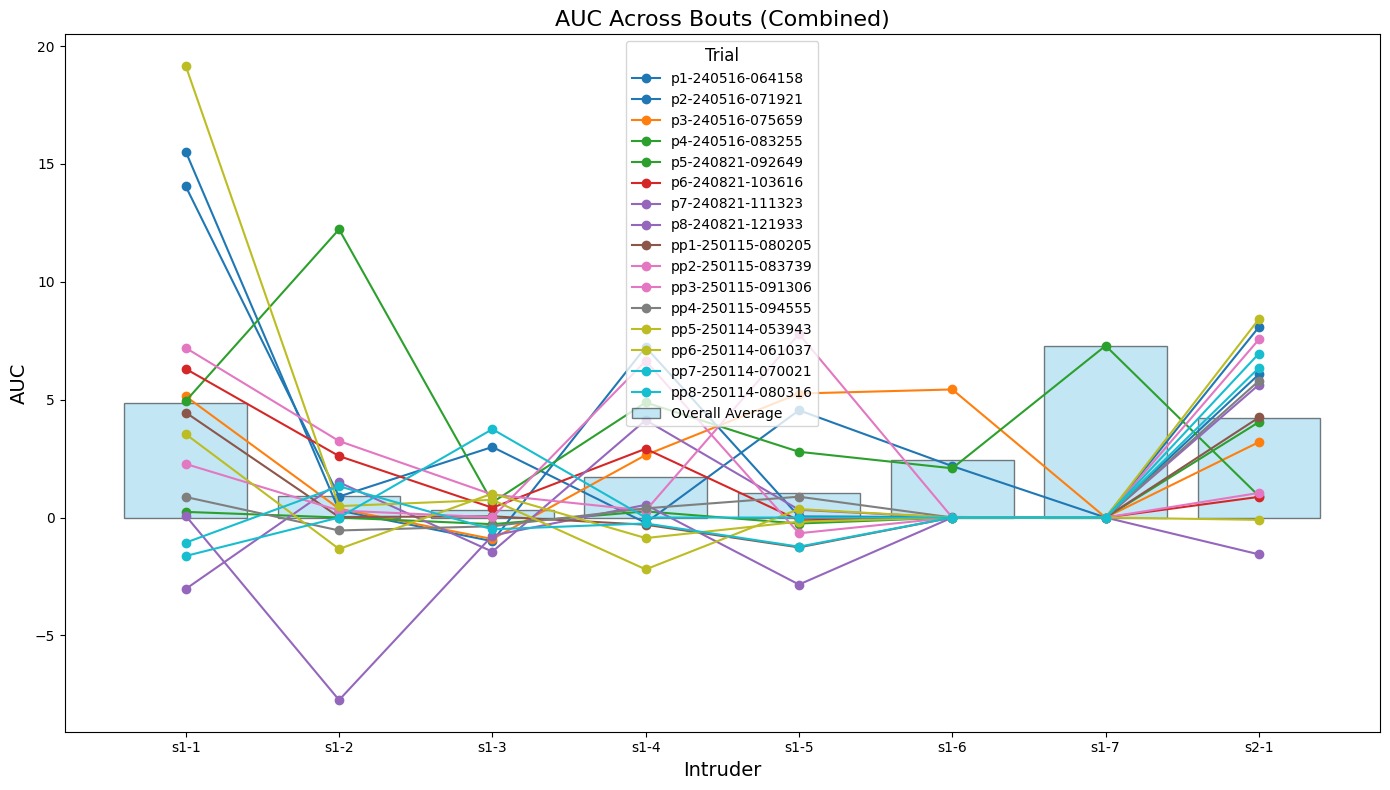

In [ ]:
# CHANGE THESE PARAMETERS
# plotting colors for a plot
plot_da_metrics_color_oneplot(experiment, 
                                 metric_name="AUC", 
                                 title="AUC Across Bouts (Combined)",
                                 ylabel="AUC",
                                 xlabel="Intruder",
                                 figsize=(14,8))